In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

In [2]:
df_combined_features = pd.read_excel(r"C:\Users\guoqi\Desktop\combined_features.xlsx")
df_combined_features

,Date,US Treasury 2Y Yield,US Treasury 10Y Yield,US IG OAS,US HY OAS,US LIBOR OIS Spread,ICE BofA MOVE Index,VIX Index,JPM Emerging Market Currency Index (EMCI) Fixing,CONSPXMD Index (UMich Expected Change in Prices During the Next Year),...,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,CAPE,yield_curve_steepness
0,1871-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1871-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1871-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1871-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1871-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851,2025-04,3.605,4.163,1.06,3.84,33.15,112.48,24.70,44.973,6.5,...,-0.005614,0.000527,-0.011814,-4.8,0.002125,0.003801,0.004585,32.5116,32.621270,4.273
1852,2025-05,3.901,4.403,0.88,3.14,33.15,92.11,18.57,45.454,6.6,...,0.001858,-0.001097,0.006591,0.0,-0.002833,-0.003154,-0.005948,20.3620,35.076007,4.263
1853,2025-06,3.721,4.230,0.83,2.90,33.15,90.26,16.73,46.099,5.0,...,-0.000008,-0.000010,-0.000010,8.5,0.000440,0.000241,-0.000050,18.3246,36.108975,4.260
1854,2025-07,3.958,4.376,0.76,2.78,33.15,79.84,16.72,45.273,4.5,...,-0.001856,-0.002425,-0.003113,1.0,NaN,NaN,-0.000290,16.4718,37.469882,4.356


In [3]:
df_1M_ret = pd.read_csv(r"C:\Users\guoqi\Desktop\Initial Data Package for Cornell Capstone Project\df_1M_ret.csv")
df_1M_ret

,Date,Russell 1000,Russell 1000 Value,Russell 1000 Growth,MSCI World ex USA Index (DM ex-US Equities),MSCI EM Index (EM Equities),US Agg Bond,US Short-term Treasury,US Long-term Treasury,US IG Corporate Bond,US HY Corporate Bond,Global Agg ex-US Bond USD Hedged,Gold,Dollar
0,2/28/1990,0.011514,0.019618,0.004243,-0.068889,0.038369,0.003236,0.004505,-0.002920,0.002901,-0.020648,-0.012310,-0.017709,0.022299
1,3/31/1990,0.022369,0.007378,0.037740,-0.100762,-0.138884,0.000737,0.001987,-0.004133,0.000912,0.026236,-0.000818,-0.096149,0.012441
2,4/30/1990,-0.027945,-0.041467,-0.014519,-0.012665,0.064746,-0.009162,0.000080,-0.023881,-0.010425,-0.001691,0.000460,-0.002035,0.012608
3,5/31/1990,0.089062,0.076765,0.100899,0.110534,0.080414,0.029608,0.017873,0.046355,0.032347,0.019296,0.024813,-0.012780,-0.003310
4,6/30/1990,-0.007778,-0.025656,0.008843,-0.010192,0.033128,0.016045,0.011715,0.023010,0.017081,0.024167,0.005767,-0.029886,-0.009962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,4/30/2025,-0.006767,-0.031830,0.017406,0.041742,0.010387,0.003929,0.010136,-0.010883,-0.000327,-0.000203,0.014946,0.060014,-0.032633
423,5/31/2025,0.062435,0.032942,0.087779,0.041540,0.039988,-0.007159,-0.003813,-0.028712,-0.000113,0.016796,-0.000670,-0.007420,-0.006179
424,6/30/2025,0.049380,0.032301,0.063034,0.022235,0.056543,0.015375,0.007523,0.024993,0.018687,0.018392,0.004998,0.003021,-0.019829
425,7/31/2025,0.021475,0.004498,0.037490,-0.012703,0.016724,-0.002639,-0.001617,-0.009006,0.000654,0.004509,0.000215,0.003468,0.019115


In [4]:
# ================= Logistic Regression Feature Selection (L1) =================
# Inputs: df_1M_ret.csv (monthly returns incl. Russell 1000)
#         combined_features.xlsx (monthly macro/market features)
# ============================================================================

RET_FILE  = r"C:\Users\guoqi\Desktop\Initial Data Package for Cornell Capstone Project\df_1M_ret.csv"
FEAT_FILE = r"C:\Users\guoqi\Desktop\combined_features.xlsx"
USE_CAPE = False
CAPE_DF  = None  

BULL_Q, BEAR_Q = 0.70, 0.30        # bull = top 30% months; bear = bottom 30%
DROP_NEUTRAL   = True              # drop middle 40%

LAG_MONTHS     = 1                 
MIN_COVERAGE   = 0.70              # target coverage on the OVERLAP with returns
MIN_COVERAGE_FLOOR = 0.30          # relax down to this if too few features pass
MIN_FEATURES_WANTED = 20           # try to keep at least this many features

N_SPLITS       = 5                 # time-series CV folds
CS             = np.logspace(-3, 2, 16)  # grid of inverse penalties C for L1
CLASS_WEIGHT   = "balanced"
MAX_ITER       = 5000
RANDOM_STATE   = 42

TOPK_PATH = 10                     
TOPK_BAR  = 20                


In [5]:
def _find_date_col(df: pd.DataFrame) -> str:
    for c in df.columns:
        if str(c).strip().lower() in ("date", "month", "time", "period"):
            return c
    return df.columns[0]

def _best_sheet_with_date(xls: pd.ExcelFile) -> str:
    best, best_cols = None, -1
    for s in xls.sheet_names:
        tmp = pd.read_excel(xls, sheet_name=s, nrows=6)
        if tmp.shape[1] == 0:
            continue
        tmp.columns = [str(c).strip() for c in tmp.columns]
        dcol = _find_date_col(tmp)
        try:
            has_any_date = pd.to_datetime(tmp[dcol], errors="coerce").notna().any()
        except Exception:
            has_any_date = False
        if has_any_date and tmp.shape[1] > best_cols:
            best, best_cols = s, tmp.shape[1]
    return best or xls.sheet_names[0]

def _to_numeric_smart(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for c in out.columns:
        s = out[c]
        if s.dtype == object:
            s = (s.astype(str).str.strip()
                            .str.replace(",", "", regex=False)
                            .str.replace("%", "", regex=False))
            s = s.replace({"": np.nan, "NA": np.nan, "NaN": np.nan, "nan": np.nan, ".": np.nan})
            out[c] = pd.to_numeric(s, errors="coerce")
        else:
            out[c] = pd.to_numeric(s, errors="coerce")
    return out

def load_returns(path: str | Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    dcol = _find_date_col(df)
    df[dcol] = pd.to_datetime(df[dcol])
    df = df.set_index(dcol).sort_index()
    df.index = pd.to_datetime(df.index.to_period("M").astype(str))
    return df

def load_features(path: str | Path) -> pd.DataFrame:
    xls = pd.ExcelFile(path)
    sheet = _best_sheet_with_date(xls)
    df = pd.read_excel(xls, sheet_name=sheet)
    df.columns = [str(c).strip() for c in df.columns]
    dcol = _find_date_col(df)
    df[dcol] = pd.to_datetime(df[dcol])
    df = df.set_index(dcol).sort_index()
    df.index = pd.to_datetime(df.index.to_period("M").astype(str))
    return df

def pick_r1k_col(df_ret: pd.DataFrame) -> str:
    cands = [c for c in df_ret.columns if "russell" in c.lower() and "1000" in c.lower()]
    if cands:
        return cands[0]
    for name in ["RUSSELL 1000", "Russell 1000", "R1000", "RUA", "RUI", "RUSSELL_1000", "Russell_1000"]:
        if name in df_ret.columns:
            return name
    eq_like = [c for c in df_ret.columns if any(k in c.lower() for k in
             ["sp", "s&p", "spx", "msci", "acwi", "world", "russell", "equity", "stock"])]
    return eq_like[0] if eq_like else df_ret.columns[0]

def make_market_labels(r1k: pd.Series, q_low: float, q_high: float, drop_mid: bool = True) -> pd.Series:
    ql, qh = r1k.quantile([q_low, q_high])
    y = pd.Series(index=r1k.index, dtype=float)
    y[r1k <= ql] = 0.0
    y[r1k >= qh] = 1.0
    return y.dropna() if drop_mid else y

def assemble_features(
    df_feat: pd.DataFrame,
    df_cape: pd.DataFrame | None,
    ret_index: pd.Index,
    min_cov: float = MIN_COVERAGE,
    min_features: int = MIN_FEATURES_WANTED,
    min_cov_floor: float = MIN_COVERAGE_FLOOR,
    use_cape: bool = USE_CAPE,
) -> pd.DataFrame:
    """
    Keep columns that meet coverage on the OVERLAP with returns.
    Relax threshold down to `min_cov_floor` until at least `min_features` remain.
    """
    X = df_feat.copy()

    # Remove CAPE-like columns from the features file unless explicitly enabled
    if not use_cape:
        X = X.drop(columns=[c for c in X.columns if "cape" in str(c).lower()], errors="ignore")

    # Join external CAPE only if requested
    if use_cape and (df_cape is not None) and (not df_cape.empty):
        X = X.join(df_cape, how="left")

    # Clean numeric, drop inf/dups/constants
    X = _to_numeric_smart(X).replace([np.inf, -np.inf], np.nan)
    X = X.loc[:, ~X.columns.duplicated()]
    var = X.var(skipna=True)
    X = X.loc[:, var > 0]

    # Coverage on overlap only
    overlap_idx = X.index.intersection(ret_index)
    X_ov        = X.loc[overlap_idx]
    cov         = X_ov.notna().mean()

    thr  = float(min_cov)
    keep = cov[cov >= thr].index.tolist()

    while (len(keep) < min_features) and (thr > min_cov_floor):
        thr = max(min_cov_floor, thr - 0.05)
        keep = cov[cov >= thr].index.tolist()

    if len(keep) == 0:  # last resort
        keep = cov.sort_values(ascending=False).index.tolist()[:min_features]

    X = X[keep]
    print(f"[assemble_features] kept {X.shape[1]} cols; overlap={overlap_idx.min().date()}→{overlap_idx.max().date()} | "
          f"threshold used={thr:.2f} | min kept overlap cov={cov[keep].min():.2f}")
    return X

def lag_and_align(X: pd.DataFrame, y: pd.Series, lag_m: int):
    X = X.copy()
    X.index = pd.to_datetime(pd.to_datetime(X.index).to_period("M").astype(str))
    y = y.copy()
    y.index = pd.to_datetime(pd.to_datetime(y.index).to_period("M").astype(str))

    X_lag = X.shift(lag_m)
    XY = pd.concat([y.rename("label"), X_lag], axis=1, join="inner")
    XY = XY.dropna(axis=0, how="any")         # rows: no NA allowed after lag
    if XY.empty:
        raise ValueError("After lagging/alignment, no rows remain.")
    return XY.drop(columns=["label"]), XY["label"].astype(int)

def build_coef_path(X: pd.DataFrame, y: pd.Series, Cs: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Coefficient path across Cs (scaler inside pipeline to avoid leakage)."""
    Cs = np.sort(np.asarray(Cs, dtype=float))
    path = []
    for C in Cs:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                penalty="l1", solver="liblinear", C=C,
                max_iter=MAX_ITER, class_weight=CLASS_WEIGHT,
                random_state=RANDOM_STATE
            )),
        ])
        pipe.fit(X.values, y.values)
        path.append(pipe.named_steps["clf"].coef_.ravel())
    return np.vstack(path), Cs

[load] returns rows=427, features rows=1856
[diag] market proxy column: Russell 1000
[assemble_features] kept 132 cols; overlap=1990-02-01→2025-08-01 | threshold used=0.70 | min kept overlap cov=0.72
[info] Final sample: rows=183, features=132 | range=2000-03-01 → 2025-05-01
[result] Best C (CV): 0.2154 | In-sample ROC AUC: 0.815


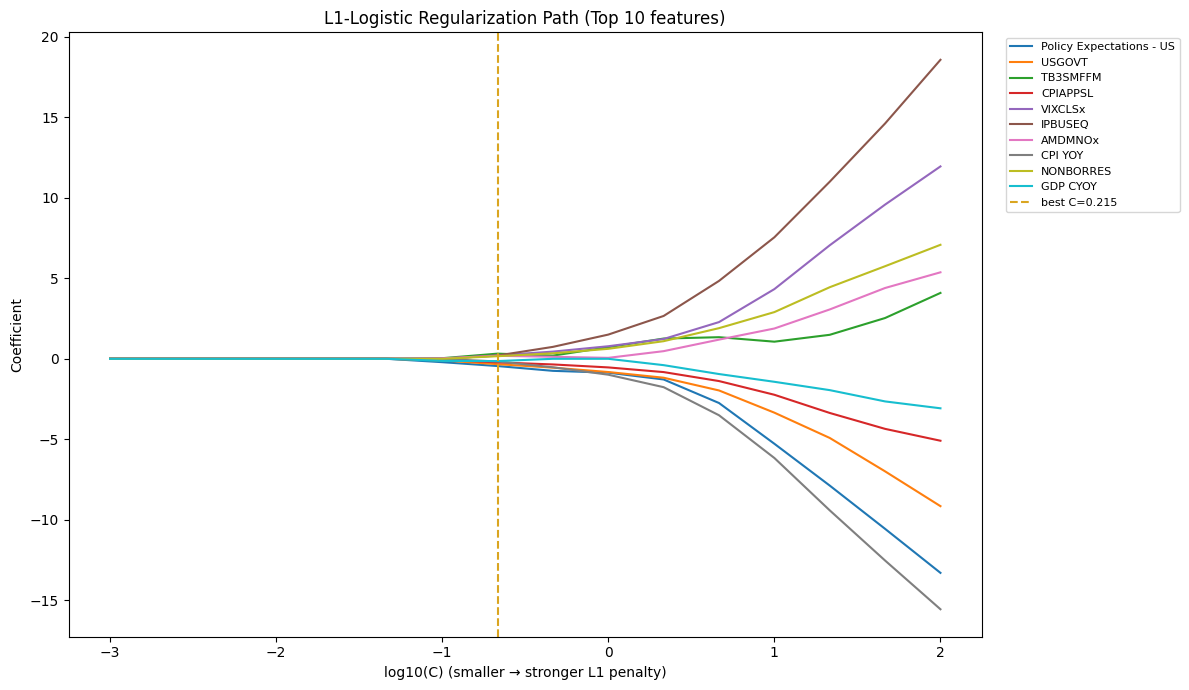


Top features by L1-Logistic (ordered by |coef| @ best C)

   Feature                    Coefficient @ best C  |Coefficient|
1   Policy Expectations - US -0.449706              0.449706     
2                     USGOVT -0.333572              0.333572     
3                   TB3SMFFM  0.320772              0.320772     
4                   CPIAPPSL -0.221803              0.221803     
5                    VIXCLSx  0.215816              0.215816     
6                    IPBUSEQ  0.204730              0.204730     
7                    AMDMNOx  0.186433              0.186433     
8                    CPI YOY -0.165991              0.165991     
9                  NONBORRES  0.161955              0.161955     
10                  GDP CYOY -0.141248              0.141248     
11                    INVEST -0.089473              0.089473     
12                   EXJPUSx  0.079933              0.079933     
13                   EXCAUSx -0.064583              0.064583     
14             CE

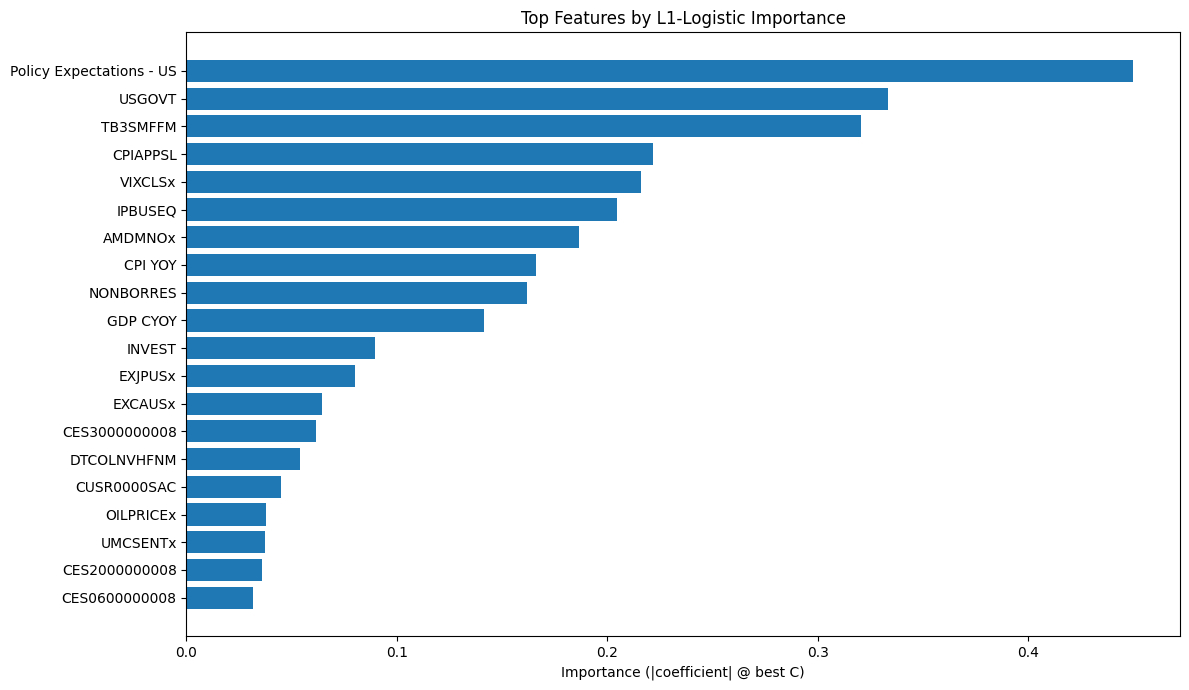

In [6]:
df_ret  = load_returns(RET_FILE)
df_feat = load_features(FEAT_FILE)
print(f"[load] returns rows={len(df_ret)}, features rows={len(df_feat)}")

# Market proxy column & monthly returns series
r1k_col = pick_r1k_col(df_ret)
print(f"[diag] market proxy column: {r1k_col}")
r1k = df_ret[[r1k_col]].dropna()
if r1k.abs().max().values[0] > 2:  # convert percents to decimals if needed
    r1k[r1k_col] = r1k[r1k_col] / 100.0

y_full = make_market_labels(r1k[r1k_col], BEAR_Q, BULL_Q, drop_mid=DROP_NEUTRAL)

# Assemble features using coverage ON THE OVERLAP with returns
X_all = assemble_features(
    df_feat, CAPE_DF, ret_index=r1k.index,
    min_cov=MIN_COVERAGE, min_features=MIN_FEATURES_WANTED,
    min_cov_floor=MIN_COVERAGE_FLOOR, use_cape=USE_CAPE
)

# Lag & align (inner join, drop NAs)
X, y = lag_and_align(X_all, y_full, LAG_MONTHS)
feature_names = list(X.columns)
print(f"[info] Final sample: rows={len(y)}, features={X.shape[1]} | range={X.index.min().date()} → {X.index.max().date()}")

# ---------------- L1-LOGIT WITH TS-CV (pipeline to avoid leakage) ----------------
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegressionCV(
        Cs=CS,
        cv=tscv,
        penalty="l1",
        solver="liblinear",
        scoring="roc_auc",
        max_iter=MAX_ITER,
        class_weight=CLASS_WEIGHT,
        refit=True,
        random_state=RANDOM_STATE,
    )),
])
pipe.fit(X.values, y.values)

logit_cv = pipe.named_steps["clf"]
best_C   = float(logit_cv.C_[0])
coef_vec = logit_cv.coef_.ravel()
y_hat    = pipe.predict_proba(X.values)[:, 1]
auc_in   = roc_auc_score(y.values, y_hat)
print(f"[result] Best C (CV): {best_C:.4g} | In-sample ROC AUC: {auc_in:.3f}")

# ---------------- REGULARIZATION PATH (Top-K at best C) ----------------
coefs_path, CS_plot = build_coef_path(X, y, CS)
ix_bestC = int(np.argmin(np.abs(CS_plot - best_C)))
abs_best = np.abs(coefs_path[ix_bestC])

top_idx = np.argsort(-abs_best)[:min(TOPK_PATH, X.shape[1])]
plt.figure(figsize=(12, 7))
for j in top_idx:
    plt.plot(np.log10(CS_plot), coefs_path[:, j], label=feature_names[j])
plt.axvline(np.log10(best_C), ls="--", color="goldenrod", label=f"best C={best_C:.3g}")
plt.xlabel("log10(C) (smaller → stronger L1 penalty)")
plt.ylabel("Coefficient")
plt.title(f"L1-Logistic Regularization Path (Top {len(top_idx)} features)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

# ---------------- RANKED LIST + BAR CHART (Top-K by |coef| @ best C) ----------------
order_bar = np.argsort(-abs_best)[:min(TOPK_BAR, X.shape[1])]
names_bar = [feature_names[i] for i in order_bar]
vals_bar  = coefs_path[ix_bestC, order_bar]      
abs_bar   = np.abs(vals_bar)

ranked = pd.DataFrame({
    "Feature": names_bar,
    "Coefficient @ best C": vals_bar,
    "|Coefficient|": abs_bar,
})
ranked.index = np.arange(1, len(ranked) + 1)
print("\nTop features by L1-Logistic (ordered by |coef| @ best C)\n")
print(ranked.to_string(index=True, justify="left"))

plt.figure(figsize=(12, 7))
ypos = np.arange(len(names_bar))
plt.barh(ypos, abs_bar)  
plt.yticks(ypos, names_bar)
plt.gca().invert_yaxis()
plt.xlabel("Importance (|coefficient| @ best C)")
plt.title("Top Features by L1-Logistic Importance")
plt.tight_layout()
plt.show()


In [7]:
# Split last N months as strict holdout
N_HOLDOUT = 60 if len(X) > 120 else max(24, len(X)//5)
split = len(X) - N_HOLDOUT
X_tr, y_tr = X.iloc[:split].values, y.iloc[:split].values
X_te, y_te = X.iloc[split:].values,  y.iloc[split:].values

# Choose C by CV on TRAIN ONLY (no leakage)
tscv = TimeSeriesSplit(n_splits=5)
cv_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegressionCV(Cs=np.logspace(-3, 2, 16),
                                 cv=tscv, penalty="l1", solver="liblinear",
                                 scoring="roc_auc", class_weight="balanced",
                                 max_iter=5000, refit=True))
])
cv_pipe.fit(X_tr, y_tr)
C_star = float(cv_pipe.named_steps["clf"].C_[0])

# Refit on TRAIN at C* and evaluate on TEST
final_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty="l1", solver="liblinear", C=C_star,
                               class_weight="balanced", max_iter=5000))
])
final_pipe.fit(X_tr, y_tr)
auc_oos = roc_auc_score(y_te, final_pipe.predict_proba(X_te)[:, 1])
print(f"[OOS] ROC AUC on holdout: {auc_oos:.3f} | C*={C_star:.3g}")


[OOS] ROC AUC on holdout: 0.570 | C*=0.215
